In [1]:
from random import random
from random import seed
seed(1)

from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Config
MFRAC = 0.5
EPOCH = 6000
gen = 9.8
# Initial guess
ni = np.array([0.000476, 3.028, 0.2249, 1.054, 0.217])
delta_n = np.array([0.0001, 0.001, 0.0001, 0.0001, 0.0001])
# Mutation step
mutation = np.array([0.09, 0.09, 0.09, 0.09, 0.09])
mutation_decay = 1e-4

In [3]:
# Read data
ydata = pd.read_csv("./data/data2.csv")

ND = ydata.shape[0]        #number of data vectors in array
DI = ydata.shape[1]        #number of data items in vector
NS = ND                    #total number of DNA strands

# log
lydata = ydata.copy()
lydata = np.log(lydata + 1e-12)

(77, 5)


In [34]:
# Functions needed
# Initialize n
def initialize(ni, delta_n):
    # Initializing n
    n = np.array([(ni + [random() for i in range(DI)] * delta_n) for i in range(ND)] )  # 45x5 randomized initial value
    return n
    
# Relative Absolute Error
def AFERR(n):
    Ferr = -lydata["HeatFlux"] + np.log(n[:, 0]) + n[:, 1] * lydata["Superheat"] + n[:, 2] * np.log(ydata["g"] + n[:, 3]*gen*ydata["SurfaceTension"]) + n[:, 4]*lydata["p"]
    aFerr = np.abs(Ferr) / np.abs(lydata["HeatFlux"])
    return aFerr

# Error and Selection
def selection(n, MFRAC=MFRAC):
    # Error calculation
    aFerr = AFERR(n)
    aFerrMean = np.mean(aFerr)
    aFerrMedian = np.median(aFerr)
    
    # Sorting
    sorted_id = np.argsort(aFerr)
    aFerr[:] = aFerr[sorted_id]
    n[:] = n[sorted_id]
    
    # Selection
    clim = MFRAC * aFerrMedian
    nkeep = np.searchsorted(aFerr, clim)
    return n, nkeep

# Mating
def mating(sorted_n, nkeep, mutation, mutation_decay, epoch=0):
    if nkeep == sorted_n.shape[0]:
        print("EPOCH %d: NOT MATING"%(epoch))
        return sorted_n
    
    for row in sorted_n[nkeep:, :]:
        # Randomly choose 2 parents
        parents = [sorted_n[np.random.randint(0, nkeep+1)] for i in range(2)]
        
        # Choose which parent to inherit from
        # inherit[i] = 0 or 1
        inherit = [np.random.randint(0, 2) for i in range(DI)]
        r = [parents[inherit[i]][i] for i in range(DI)]
        
        # Mutation
        mut_rate = [(2*(0.5-np.random.rand())) for i in range(DI)]
        row[:] = r * (1 + mut_rate * mutation)
        if mutation_decay:
            mutation[:] = mutation * (1-mutation_decay)
    return sorted_n
        
# Train
def train(EPOCH=300, ni=ni, delta_n=delta_n, MFRAC=MFRAC, mutation=mutation, mutation_decay=0):
    n = initialize(ni, delta_n)
    n_means, aFerr_means = [], []
    n_best = np.array([0.0 for i in range(DI)])
    aFerr_min, best_epoch = 1, 0

    for epoch in range(EPOCH):
        sorted_n, nkeep = selection(n, MFRAC)
        n = mating(sorted_n, nkeep, mutation, mutation_decay, epoch)
        # statistic features
        n_mean = np.mean(n, axis=0)
        aFerr_mean = np.mean(AFERR(n_mean.reshape(1,-1)))

        n_means.append(n_mean)
        aFerr_means.append(aFerr_mean)
        if aFerr_mean < aFerr_min:
            aFerr_min = aFerr_mean
            n_best[:] = n_mean
            best_epoch = epoch

    # Result
    print("ENDING: n: {}, aFerrmean: {}".format(n_mean, aFerr_mean))
    print("OPTIM: n: {}, aFerrmean: {}, BestEpoch: {}".format(n_best, aFerr_min, best_epoch))
    return n_means, aFerr_means, n_best, aFerr_min, best_epoch 


# Plotting
def const_error(n_means, aFerr_means, i=-1, sub=111):
    n_means = np.array(n_means)
    x = range(n_means.shape[0])
    # Plotting
    plt.subplot(sub)
    if i >= 0:
        plt.title("Initial Guess: {}\nMutation Magnitude: {}".format(nis[i], mutations[i]))
    plt.xlabel("Epochs")
    plt.ylabel("Constants and Error")
    plt.plot(x, n_means[:, 0], label="n1")
    plt.plot(x, n_means[:, 1], label="n2")
    plt.plot(x, n_means[:, 2], label="n3")
    plt.plot(x, n_means[:, 3], label="n4")
    plt.plot(x, n_means[:, 4], label="n5")
    plt.plot(x, aFerr_means, label="aFerr")
    plt.legend()
    plt.loglog()
    
def pred_true(n, label):
    # Calculating y_pred
    n = n.reshape(1,-1)
    y_pred = np.log(n[:, 0]) + n[:, 1] * lydata["Superheat"] + n[:, 2] * np.log(ydata["g"] + n[:, 3]*gen*ydata["SurfaceTension"]) + n[:, 4]*lydata["p"]
    y_pred = np.exp(y_pred)
    y_true = ydata["HeatFlux"]
    # Plotting
    plt.scatter(y_pred, y_true, label=label)

# Deviation and other statistic results
def stat(n):
    n = n.reshape(1,-1)
    y_pred = np.exp(np.log(n[:, 0]) + n[:, 1] * lydata["Superheat"] + n[:, 2] * np.log(ydata["g"] + n[:, 3]*gen*ydata["SurfaceTension"]) + n[:, 4]*lydata["p"])
    y_true = ydata["HeatFlux"]
    relErr = (y_pred-y_true) / y_true
    mean = np.sqrt((np.mean(relErr * relErr) / relErr.shape[0]))
    dev = np.std(relErr)
    unacc_rate = np.where((relErr > 0.1)| (relErr < -0.1))[0].shape[0] / relErr.shape[0]
    print("RMSError: %f, RMSDeviation: %f, Unacceptable Rate: %f"%(mean, dev, unacc_rate))
    return mean, dev, unacc_rate

In [27]:
# Main
nis = [
    np.array([0.000476, 3.028, 0.2249, 1.054, 0.217]),
    np.array([0.0008, 2, 0.5, 2, 1]),
    np.array([0.0003, 1.5, 0.8, 3, 1.2]),
    np.array([0.0002, 3, 0.3, 2.2, 0.7])
]
mutations = [
    np.array([0.09 for i in range(DI)]),
    np.array([0.09 for i in range(DI)]),    # doesn't converge for 0.09
    np.array([0.09 for i in range(DI)]),
    np.array([0.09 for i in range(DI)])
]

results = []
for i in range(4):
    res = train(EPOCH, nis[i], delta_n, MFRAC, mutations[i])
    results.append(res)


ENDING: n: [1.55824599e-04 2.88706433e+00 2.21045219e-01 2.75879552e+00
 9.92328309e-01], aFerrmean: 0.03157856389677145
OPTIM: n: [1.54582393e-04 2.97637327e+00 3.45358598e-01 1.79838814e+00
 6.69007085e-01], aFerrmean: 0.02335932109725768, BestEpoch: 5196
ENDING: n: [3.59958912e-04 2.95010811e+00 5.81659247e-02 4.80935959e-01
 8.14761712e-01], aFerrmean: 0.037244562030597415
OPTIM: n: [6.61945872e-04 2.67533181e+00 3.71236486e-01 1.71618404e+00
 4.26618160e-01], aFerrmean: 0.02347425643057111, BestEpoch: 505
ENDING: n: [1.28439258e-04 2.97136164e+00 3.16973099e-01 2.05586354e+00
 7.56656302e-01], aFerrmean: 0.028973055409693305
OPTIM: n: [1.66915082e-04 2.94643161e+00 4.14293100e-01 1.57164065e+00
 5.74150283e-01], aFerrmean: 0.021508886483784583, BestEpoch: 5524
ENDING: n: [8.97588740e-05 3.07391163e+00 1.93609344e-01 6.11766265e+00
 1.00739106e+00], aFerrmean: 0.03856633165187014
OPTIM: n: [1.06485587e-04 3.00404656e+00 3.63740094e-01 2.01754550e+00
 7.47470214e-01], aFerrmean: 0.0

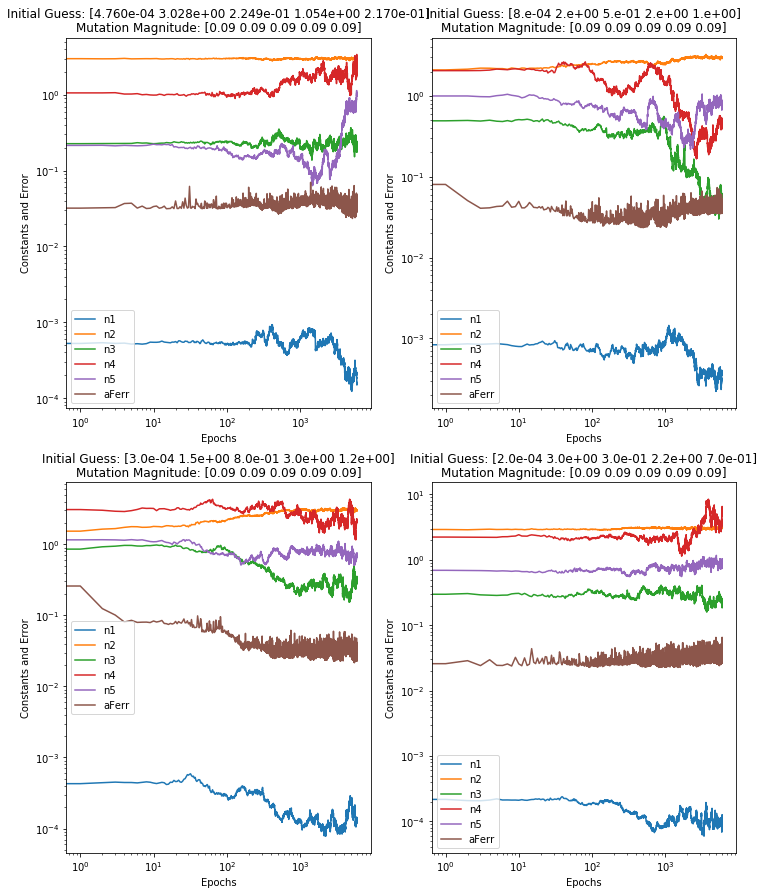

In [28]:
# Plotting
plt.figure(figsize=(12,15))
for (i, (n_means, aFerr_means, n_best, aFerr_min, best_epoch)) in enumerate(results):
    const_error(n_means, aFerr_means, i, 221+i)
plt.savefig("./result/const_and_error_5.png")

In [48]:
# n_means, aFerr_means, n_best, aFerr_min, best_epoch = results[2]
# np.save("./result/gene5_0", n_best)

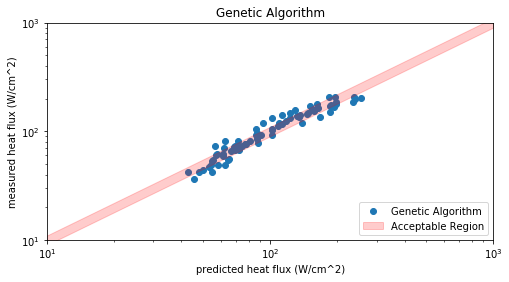

In [46]:
n_best = np.load("./result/gene5_0.npy")
plt.figure(figsize=(8,4))
pred_true(n_best, "Genetic Algorithm")
r = np.linspace(10, 1000, 3)
y1 = 1.1 * r
y2 = 0.9 * r
plt.fill_between(r, y1, y2, color="r", alpha=0.2, label="Acceptable Region")

plt.title('Genetic Algorithm')
plt.xlabel('predicted heat flux (W/cm^2)')
plt.ylabel('measured heat flux (W/cm^2)')
plt.loglog()
plt.legend(loc="lower right")
plt.xlim(xmax = 1000, xmin = 10)
plt.ylim(ymax = 1000, ymin = 10)
plt.savefig("./result/pred_true_5.png")

In [47]:
stat(n_best)

RMSError: 0.014840, RMSDeviation: 0.128929, Unacceptable Rate: 0.428571


(0.014840427587722478, 0.12892941504510178, 0.42857142857142855)

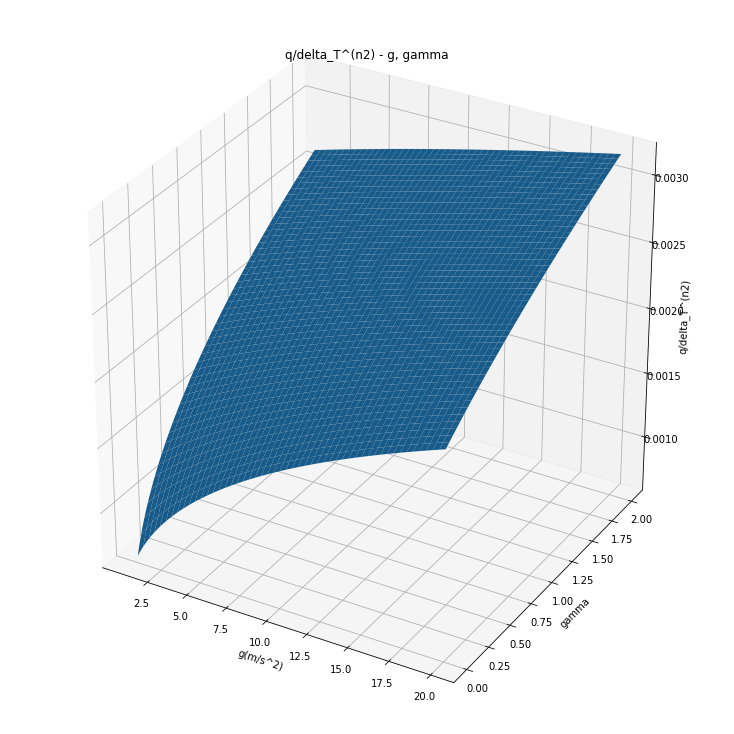

In [100]:
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

n1, n2, n3, n4, n5 = n_best
x = np.linspace(1, 20, 1000)
y = np.linspace(0.001, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = n1 * np.power((X + n4 * gen * Y), n3) * np.power(10, n5)
ax.plot_surface(X, Y, Z)
ax.set_xlabel("g(m/s^2)")
ax.set_ylabel("gamma")
ax.set_zlabel("q/delta_T^(n2)")
plt.title("q/delta_T^(n2) - g, gamma")
plt.savefig("./result/q_g_gamma.png")

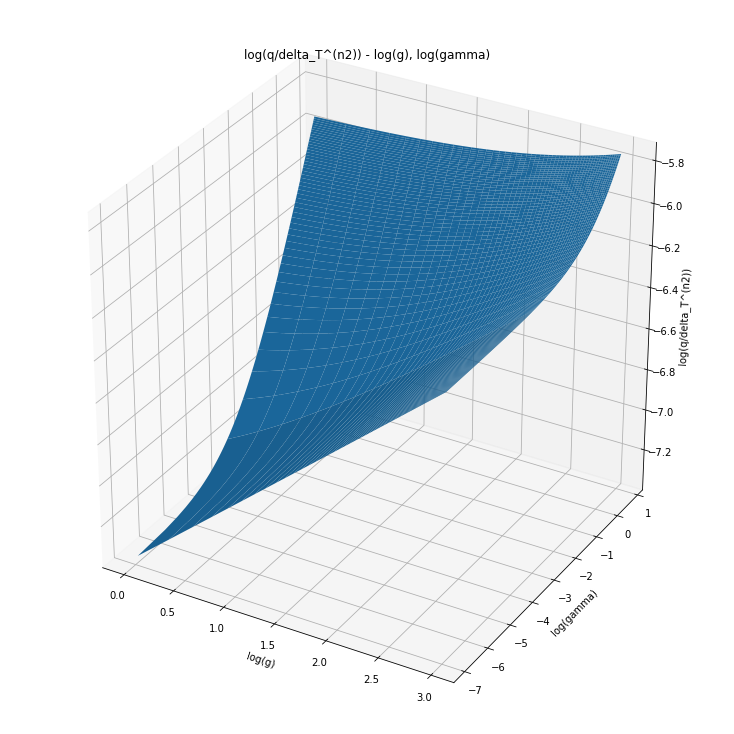

In [99]:
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

n1, n2, n3, n4, n5 = n_best
x = np.linspace(1, 20, 1000)
y = np.linspace(0.001, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = n1 * np.power((X + n4 * gen * Y), n3) * np.power(10, n5)

logX = np.log(X)
logY = np.log(Y)
logZ = np.log(Z)
ax.plot_surface(logX, logY, logZ)
ax.set_xlabel("log(g)")
ax.set_ylabel("log(gamma)")
ax.set_zlabel("log(q/delta_T^(n2))")
plt.title("log(q/delta_T^(n2)) - log(g), log(gamma)")
plt.savefig("./result/q_g_gamma_log.png")